In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import os
import glob
from scipy.signal import find_peaks

In [4]:
def df_to_1d(df: pd.DataFrame, method="coarseness") -> pd.DataFrame:
    """assuming the df is channels 0 through 8, 
    this transforms it into a 1d vibrometry signal using specified method
    """
    df = df.copy()
    
    if method == "coarseness":
        #mean subtraction i.e. DC component removal
        instantaneous_mean = df.mean(axis=1)
        for col in df.columns:
            df[col] = df[col] - np.array(instantaneous_mean)

        #1d generation
        def gen1d(row):
            ss = 0
            for i in range(0,row.shape[0]):
                for j in range(0,row.shape[0]):
                    if i != j and i<j:#upper triangular
                        ss += np.abs(row[i]-row[j])
            ss /= row.shape[0]*row.shape[0]/2 - row.shape[0]
            return ss
        
        df = df.apply(gen1d, axis=1, raw=True, result_type="reduce")
    return df

In [5]:
# read all csv files in data_all_to_off/* and concatenate them
path = 'data_all_to_off/'
all_files = glob.glob(os.path.join(path, "*.csv"))
all_files.sort() #sort by time. lasers were turned off one by one.
all_df = [pd.read_csv(f, header=0) for f in all_files] 

all_1d_coarseness = [df_to_1d(df, method="coarseness") for df in all_df]

fundamental: 132.81 Hz detected at index 34


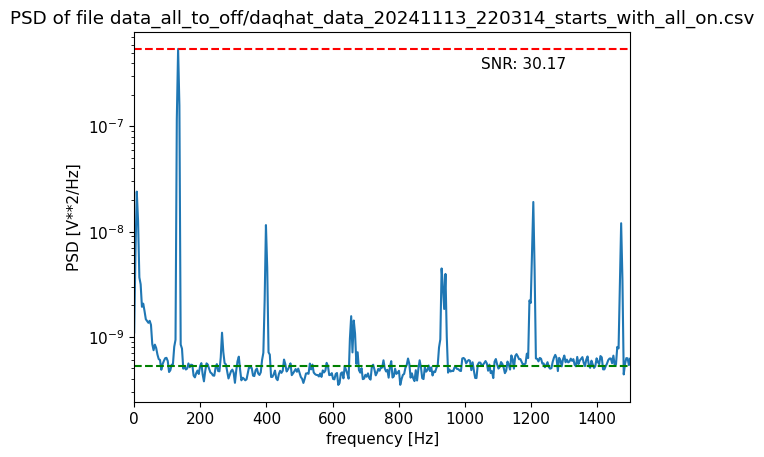

fundamental: 132.81 Hz detected at index 34


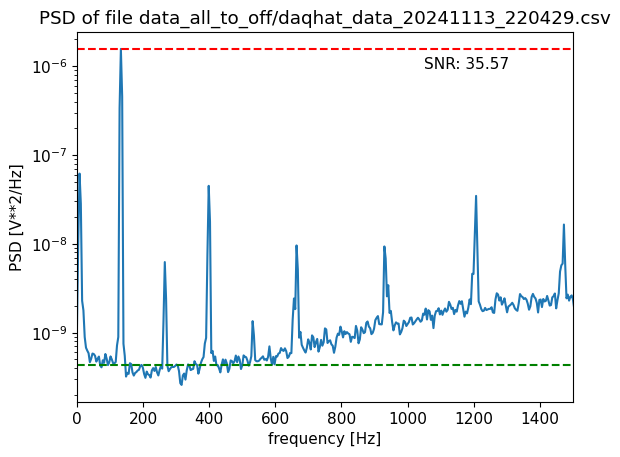

fundamental: 132.81 Hz detected at index 34


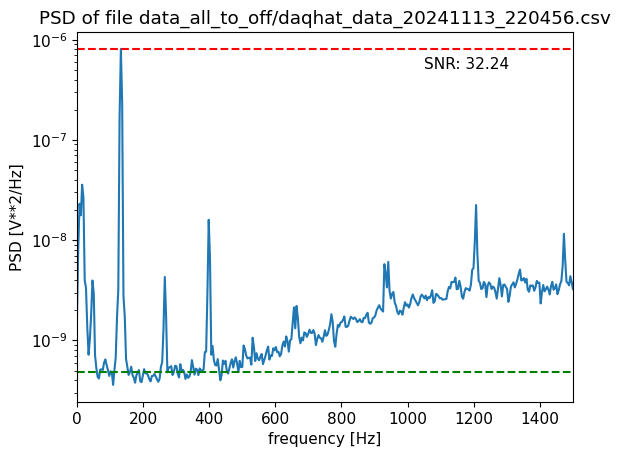

fundamental: 7.81 Hz detected at index 2


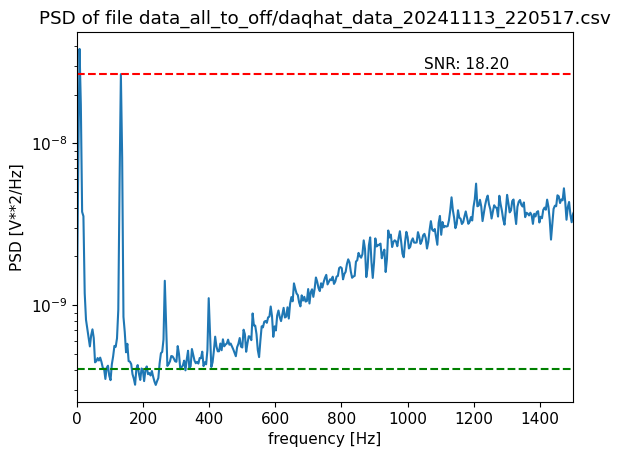

fundamental: 132.81 Hz detected at index 34


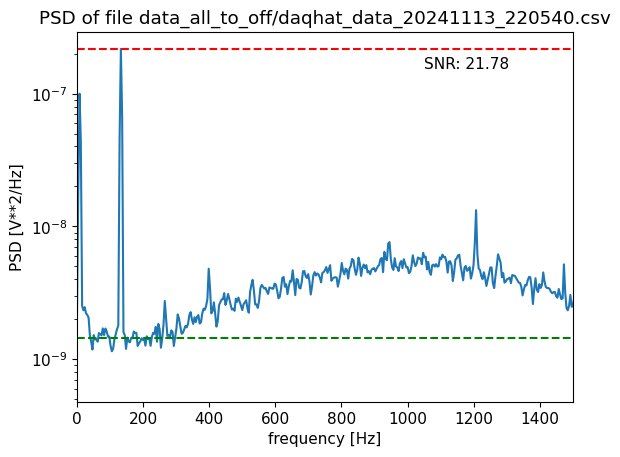

fundamental: 132.81 Hz detected at index 34


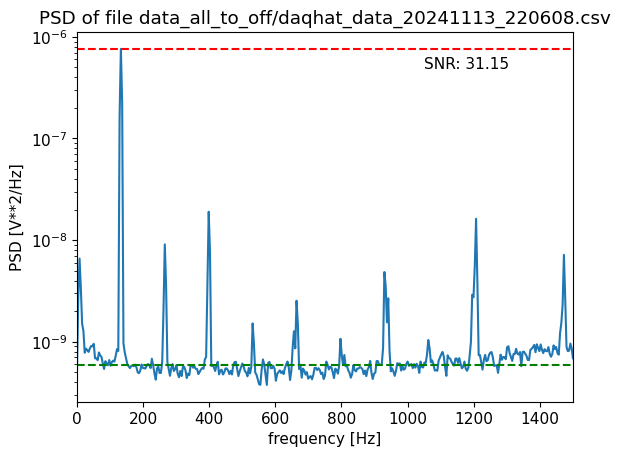

fundamental: 3.91 Hz detected at index 1


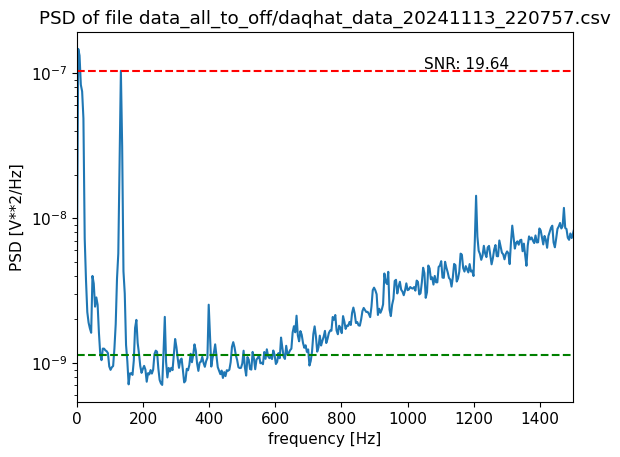

fundamental: 132.81 Hz detected at index 34


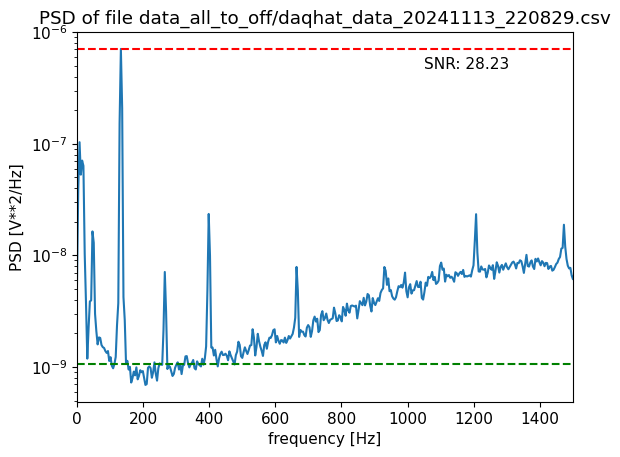

fundamental: 132.81 Hz detected at index 34


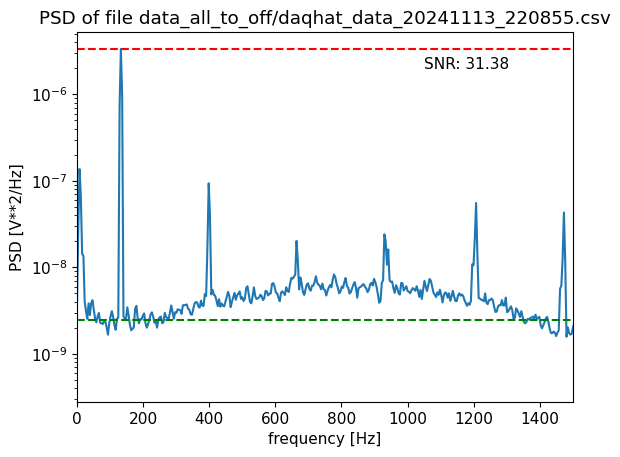

fundamental: 132.81 Hz detected at index 34


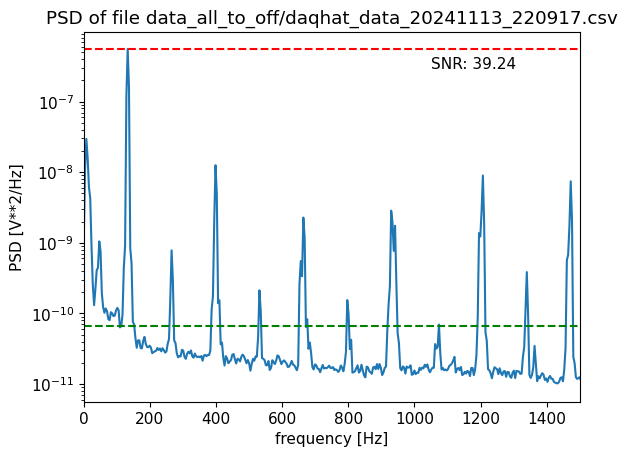

fundamental: 132.81 Hz detected at index 34


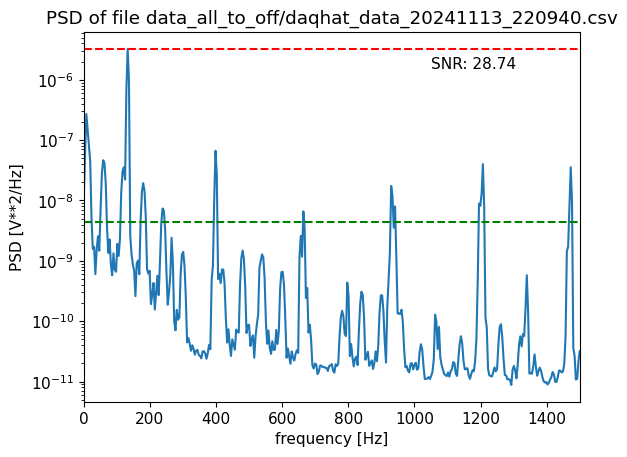

fundamental: 132.81 Hz detected at index 34


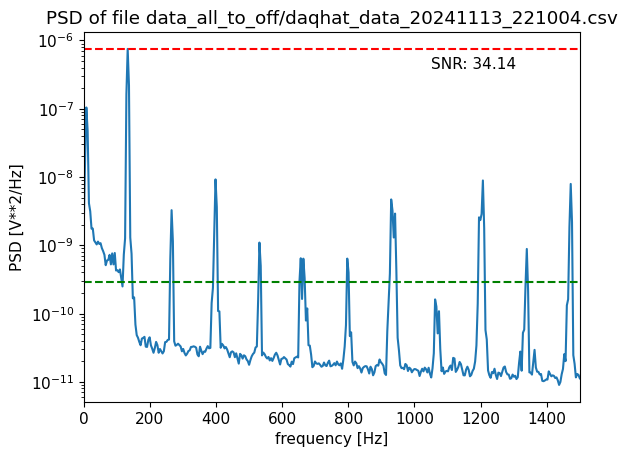

fundamental: 132.81 Hz detected at index 34


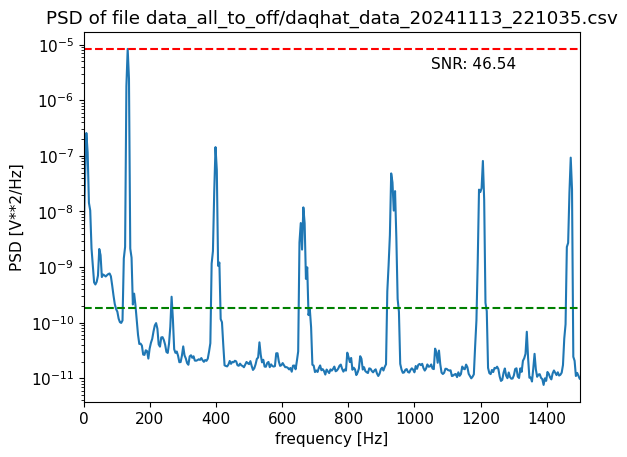

fundamental: 7.81 Hz detected at index 2


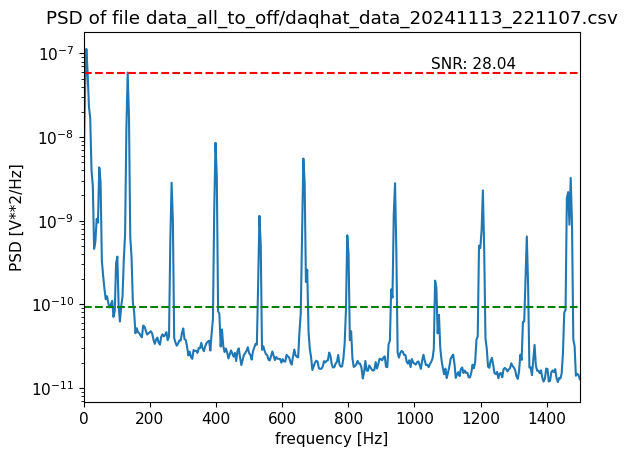

fundamental: 132.81 Hz detected at index 34


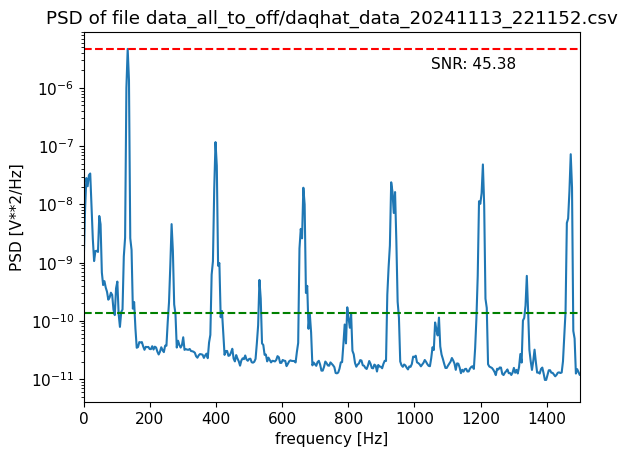

fundamental: 132.81 Hz detected at index 34


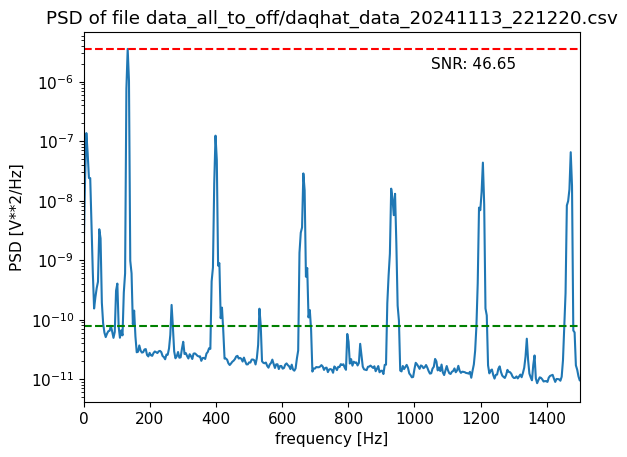

fundamental: 132.81 Hz detected at index 34


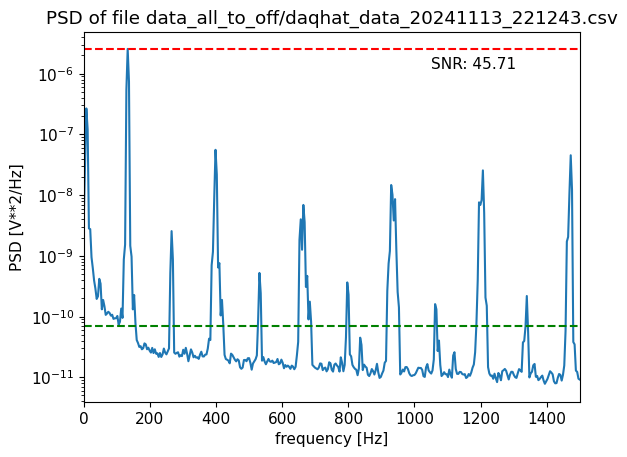

fundamental: 132.81 Hz detected at index 34


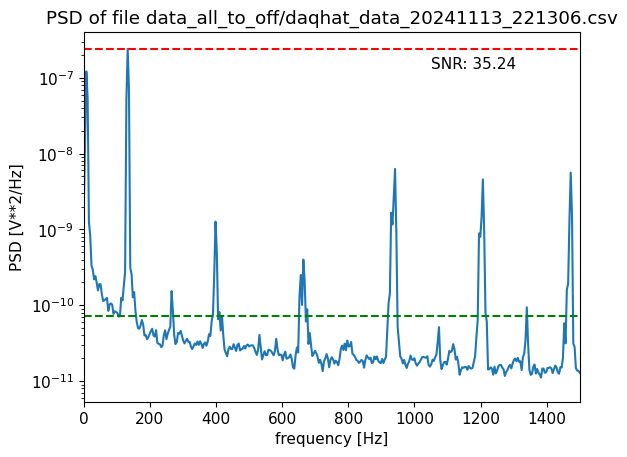

fundamental: 132.81 Hz detected at index 34


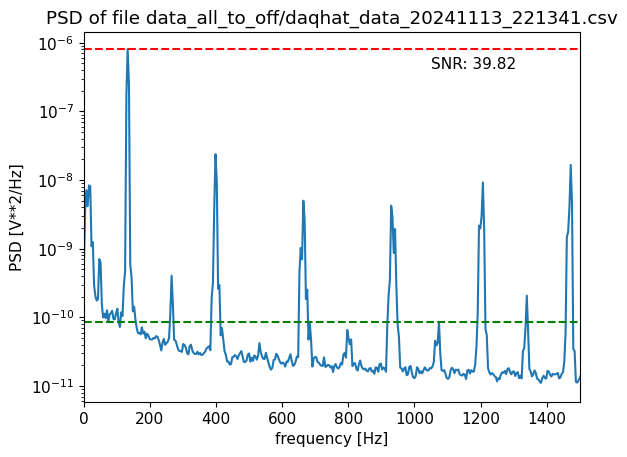

fundamental: 132.81 Hz detected at index 34


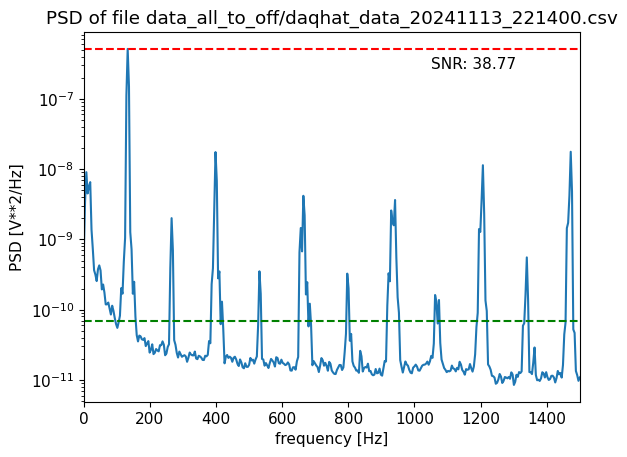

fundamental: 132.81 Hz detected at index 34


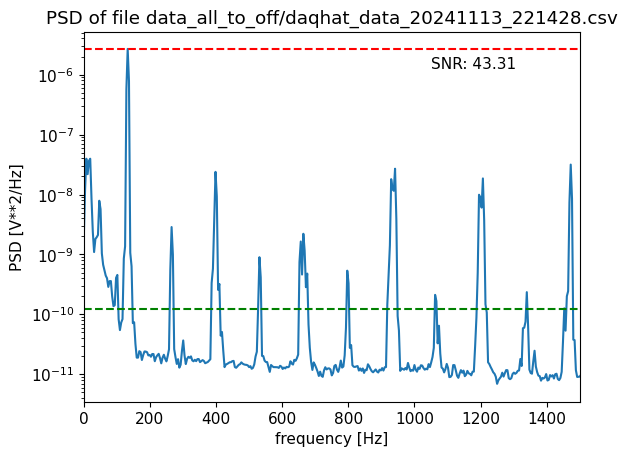

fundamental: 132.81 Hz detected at index 34


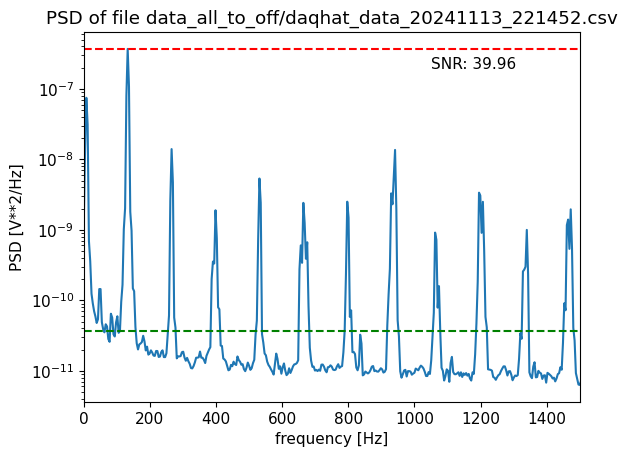

fundamental: 132.81 Hz detected at index 34


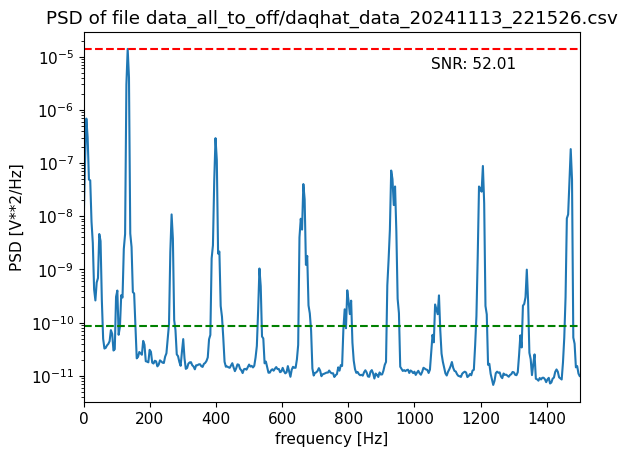

fundamental: 132.81 Hz detected at index 34


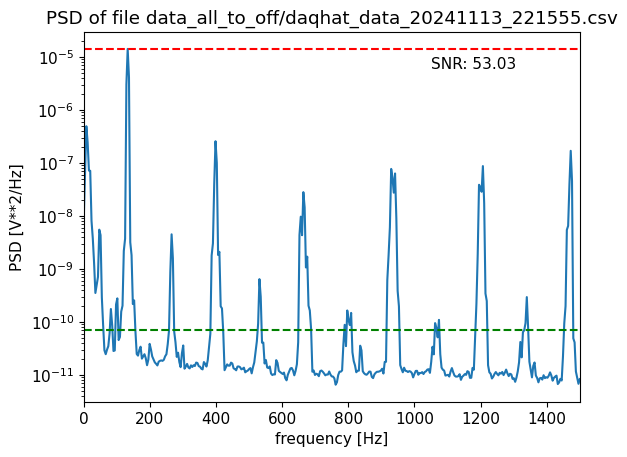

fundamental: 132.81 Hz detected at index 34


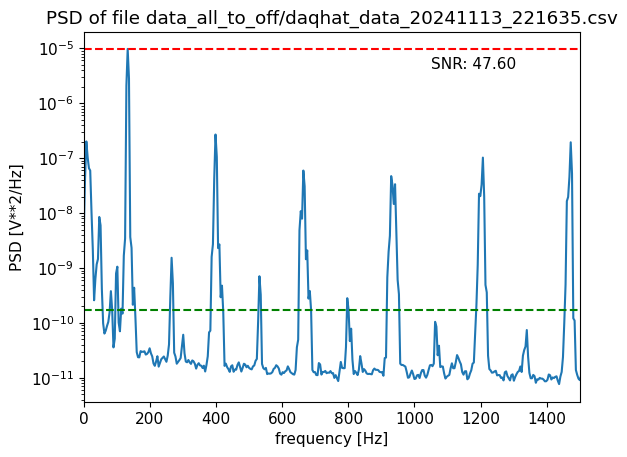

fundamental: 132.81 Hz detected at index 34


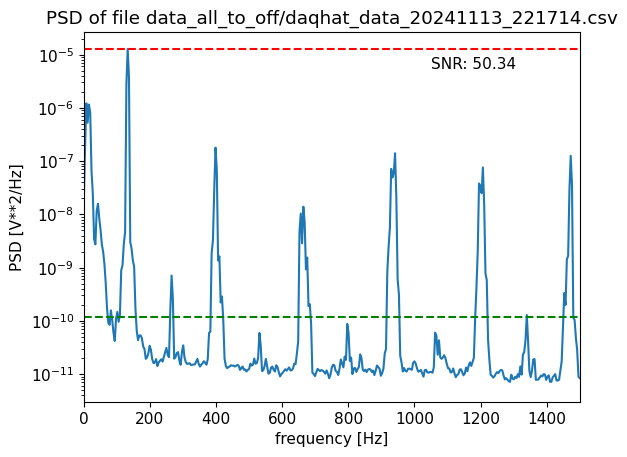

fundamental: 1917.97 Hz detected at index 491


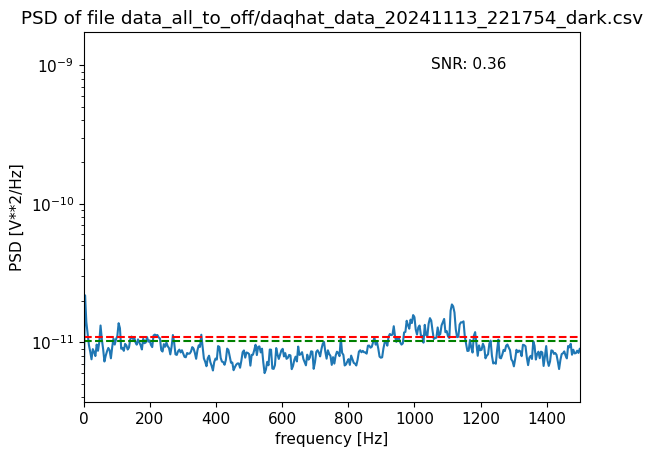

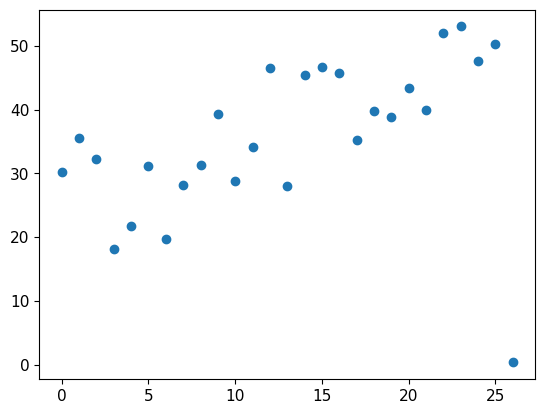

In [46]:
SNRs = []
signal_powers = []
# create a PSD plot for each file
for i,data in enumerate(all_1d_coarseness):
    fs =  4000
    f, Pxx_den = signal.welch(data, fs, nperseg=1024)
    
    f_signal_min=30#index where the true signal 133hz is, is 34
    f_signal_max=40
    signal_power = np.max(Pxx_den[f_signal_min:f_signal_max])
    noise_power =(np.mean(Pxx_den[f_signal_min-10:f_signal_min]) + np.mean(Pxx_den[f_signal_max:f_signal_max+10]) )/ 2
    snr = 10*np.log10(signal_power / noise_power)
    
    peaks, props = find_peaks(Pxx_den, height=noise_power*4) 
    
    fundamental_idx = peaks[np.argmax(props['peak_heights'])]
    f1_detected = f[fundamental_idx]
    print(f"fundamental: {f1_detected:.2f} Hz detected at index {fundamental_idx}")
        
    #plt.semilogy(f[peaks], Pxx_den[peaks], "x")
    
    SNRs.append(snr)
    signal_powers.append(signal_power)
        
    plt.semilogy(f, Pxx_den)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('PSD of file {}'.format(all_files[i]))
    plt.annotate('SNR: {:.2f}'.format(snr), xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlim(0, 1500)

    plt.axhline(signal_power, color='r', linestyle='--')

    plt.axhline(noise_power, color='g', linestyle='--')
    plt.show()
    plt.close()

#this plot shows increasing SNR as more lasers are turned on
plt.plot(SNRs, 'o') #need to show trend line

(1079220,)
(513, 2106)


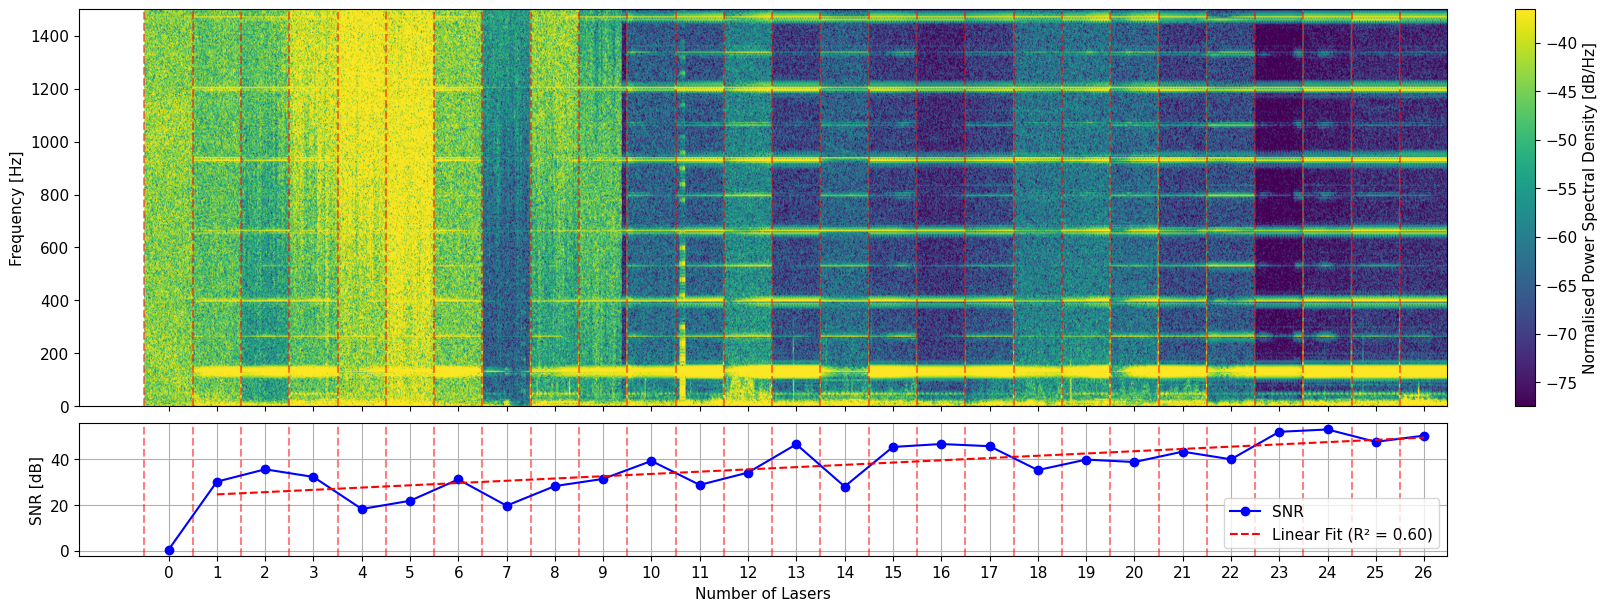

In [53]:
centered_signals = []
for sig in all_1d_coarseness:
    centered = sig - np.mean(sig)
    centered = centered / np.std(centered)
    centered_signals.append(centered)

#move the off signal to the beginning, so we can start at 0 lasers
centered_signals = centered_signals[-1:] + centered_signals[:-1]
SNRs = SNRs[-1:] + SNRs[:-1]
concatenated_signal = np.concatenate(centered_signals)


print(concatenated_signal.shape)

#STFT
nperseg = 1024
noverlap = nperseg // 2
fs = 4000

f, t, Sxx = signal.spectrogram(concatenated_signal, fs=fs, nperseg=nperseg, 
                              noverlap=noverlap, scaling='density')

Sxx_db = 10 * np.log10(Sxx)
print(Sxx.shape)
x_len_stft = Sxx.shape[1]//len(centered_signals)

#normalize with OFF as reference
vmin = np.percentile(Sxx_db[-x_len_stft], 5)
vmax = np.percentile(Sxx_db[-x_len_stft], 95)

plt.rcParams.update({'font.size': 11})  # Increase base font size

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,6), height_ratios=[3, 1], sharex=True, layout='constrained')

#spectrogram with normalized colorscale
im = ax1.pcolormesh(t, f, Sxx_db, shading='gouraud', vmin=vmin, vmax=vmax, cmap='viridis')
fig.colorbar(im, ax=ax1, label='Normalised Power Spectral Density [dB/Hz]')

segment_lengths = [len(sig) for sig in centered_signals]
segment_times = np.cumsum([0] + segment_lengths) / fs

for i in range(len(centered_signals)):
    ax1.axvline(segment_times[i], color='r', linestyle='--', alpha=0.5)
    ax2.axvline(segment_times[i], color='r', linestyle='--', alpha=0.5)

experiment_ticks = [(segment_times[i] + segment_times[i+1])/2 for i in range(len(centered_signals))]
experiment_labels = [str(i) for i in range(len(centered_signals))]


ax1.set_ylabel('Frequency [Hz]')
ax1.set_ylim(0, 1500) 
x = np.arange(len(SNRs)-1)  # exclude last point
z = np.polyfit(x, SNRs[1:], 1) 
p = np.poly1d(z)

#R^2 excluding last point
correlation_matrix = np.corrcoef(SNRs[1:], p(x))
r_squared = correlation_matrix[0,1]**2

ax2.plot(experiment_ticks, SNRs, 'bo-', label='SNR')

#trendline
trend_x = experiment_ticks[1:]
ax2.plot(trend_x, p(x), 'r--', 
         label=f'Linear Fit (R² = {r_squared:.2f})')

ax2.legend()
ax2.set_xticks(experiment_ticks, experiment_labels)
ax2.set_xlabel('Number of Lasers')
ax2.set_ylabel('SNR [dB]')
ax2.grid(True)
#fig.suptitle('Spectral Analysis of 133 Hz Surface Vibration and SNR Performance with Multi Laser Sources', y=1.02)
plt.show()

#save as pdf
fig.savefig('multilaser_spectrogram.png', format='png')